In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2

n_site = x_dimension * y_dimension

U = 8
t = 1.0
t_prime = 0.3
mu = 0.0

# Exact part

## Find eigenvalues for different electron counts.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
n_electrons_eigvals = []

for n_electrons in range(2 * n_site + 1):

    valid_indices = []
    for bits in product('01', repeat= 2 * x_dimension * y_dimension):
        
        if bits.count('1') == n_electrons:
            binary_str = ''.join(bits)
            valid_indices.append(int(binary_str, 2))

    indices = jnp.array(valid_indices)

    H_reduced = reduced_hubbard_model(U=U, indices=indices)

    H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
    n_electrons_eigvals.append(H_reduced_eigvals)
    print(f"Eigenvalues of {n_electrons} electrons:", jnp.round(H_reduced_eigvals[:5], 3))

Eigenvalues of 0 electrons: [0.]
Eigenvalues of 1 electrons: [-5.2 -5.2  1.2  1.2  1.2]
Eigenvalues of 2 electrons: [-9.054 -4.    -4.    -4.    -4.   ]
Eigenvalues of 3 electrons: [-6.549 -6.549 -6.549 -6.549 -5.302]
Eigenvalues of 4 electrons: [-4.205 -3.613 -3.613 -3.613 -2.842]
Eigenvalues of 5 electrons: [2.8  2.8  2.8  2.8  3.24]
Eigenvalues of 6 electrons: [11.128 12.    12.    12.    12.   ]
Eigenvalues of 7 electrons: [21.2 21.2 22.8 22.8 22.8]
Eigenvalues of 8 electrons: [32.]


## Find the electron count in the ground state.

In [5]:
n_electrons_ground_eigvals = [subarray[0] for subarray in n_electrons_eigvals]
n_electrons_ground_eigvals = jnp.array(n_electrons_ground_eigvals)
# 找到最小值的索引
ground_state_electron_counts = jnp.argmin(n_electrons_ground_eigvals)
print('ground_state_electron_counts:', ground_state_electron_counts)

ground_state_electron_counts: 2


## Construct the reduced Hamiltonian.

In [6]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):
    
    if ground_state_electron_counts - 1 <= bits.count('1') <= ground_state_electron_counts + 1:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues of {ground_state_electron_counts-1} ~ {ground_state_electron_counts+1} electrons:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 92
Eigenvalues of 1 ~ 3 electrons: [-9.054 -6.549 -6.549 -6.549 -6.549 -5.302 -5.302 -5.2  ]


# Determinant method

## Construct the Hamiltonian.

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-10.4  -9.2  -9.2  -9.2  -9.2  -7.6  -7.6  -5.2]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:2])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [1, 4, 2, 2, 8, 12, 4, 16, 2, 4, 6, 2, 4, 8, 12, 1, 4]
Number of degerate Eigenvalues:
 [1, 4]
Eigenvalues of first Hi: 
 [0.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

# Binary search

# error $ = 10^{-3}$

In [12]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [13]:
U_sweep = jnp.linspace(0, U, 11)

In [14]:
H0_eigvals_updated

Array([-10.4,  -9.2,  -9.2,  -9.2,  -9.2], dtype=float64)

In [15]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 7 iterations.
-10.20923846235885
solve: 2
Converged in 7 iterations.
-10.03349481203081
solve: 3
Converged in 7 iterations.
-9.872069359868739
solve: 4
Converged in 7 iterations.
-9.72363062550911
solve: 5
Converged in 6 iterations.
-9.587632227599737
solve: 6
Converged in 6 iterations.
-9.46253057201191
solve: 7
Converged in 6 iterations.
-9.348874595643847
solve: 8
Converged in 6 iterations.
-9.246586119589095
solve: 9
Converged in 6 iterations.
-9.154395602362175
solve: 10
Converged in 6 iterations.
-9.069099655226356


In [16]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

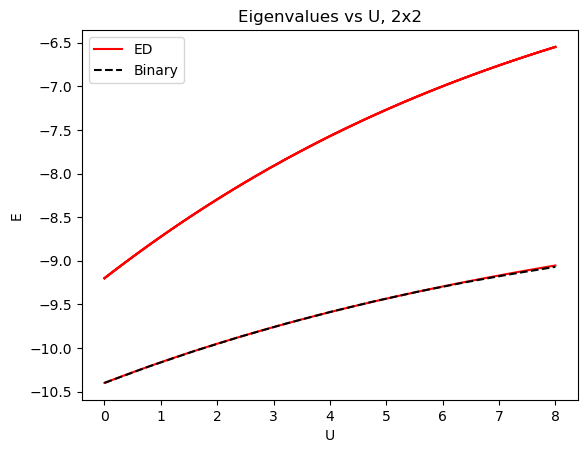

In [17]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [18]:
def _Psi_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N
    
    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    Heff =  jnp.real(Hij + Rij)
    Heff_eigvals, Heff_eigvecs = jnp.linalg.eigh(Heff)

    
    
    Proj_Psi = degeneracy_eigvecs @ Heff_eigvecs
    Psi = Proj_Psi + Q @ M_inv @ Q @ H @ Proj_Psi

    Psi_norm = jnp.zeros_like(Psi)
    for i in range(degeneracy_dim):
        Psi_norm = Psi_norm.at[:,i].set(Psi[:,i]/jnp.linalg.norm(Psi[:,i]))

    return Psi_norm

In [19]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

## Green's function

## Annihilation and creation operator


In [20]:
X = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
Y = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
Z = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
I = sp.eye(2, dtype=complex, format='csr')

def reduced_annihilation_operator(n_site, index, indices):
    N = 2 * n_site

    Z_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(index - 1):
        Z_tensor = sp.kron(Z_tensor, Z, format='csr')

    middle_part = 0.5 * (X + 1j * Y)
    
    I_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(N - index):
        I_tensor = sp.kron(I_tensor, I, format='csr')
    
    a_i = sp.kron(sp.kron(Z_tensor, middle_part, format='csr'), I_tensor, format='csr')
    
    return a_i[jnp.ix_(indices, indices)].toarray()

## Retarded Green's function
### $$ G^{R}_{ij}(\omega) = \bra{\Psi_0}\hat{a}_i(\omega-(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_j^\dagger\ket{\Psi_0} +\bra{\Psi_0}\hat{a}_j^\dagger(\omega+(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_i\ket{\Psi_0} $$

In [21]:
def reduced_retarded_Greens_func_ij(H, z, ground_eigval, ground_eigvec, index_i, index_j, n_site, indices):

    dim = len(indices)
    
    a_i = reduced_annihilation_operator(n_site, index_i, indices)
    a_j = reduced_annihilation_operator(n_site, index_j, indices)

    eta = 1E-5

    plus_denominator = (z + ground_eigval + 1j * eta) * jnp.eye(dim) - H
    minus_denominator = (z - ground_eigval + 1j * eta) * jnp.eye(dim) + H

    plus_denominator_inv = jnp.linalg.inv(plus_denominator)
    minus_denominator_inv = jnp.linalg.inv(minus_denominator)

    Gij = ground_eigvec @ a_i @ plus_denominator_inv @ a_j.T @ ground_eigvec \
            + ground_eigvec @ a_j.T @ minus_denominator_inv @ a_i @ ground_eigvec
    
    return Gij

In [22]:
singularity_energy = jnp.array([])
Exact_ground_state = H_reduced_eigvals[0]

for En in n_electrons_eigvals[ground_state_electron_counts-1]:
    singularity_energy = jnp.append(singularity_energy, Exact_ground_state-En)
for En in n_electrons_eigvals[ground_state_electron_counts+1]:
    singularity_energy = jnp.append(singularity_energy, En-Exact_ground_state)
singularity_energy = singularity_energy.sort()
print(singularity_energy)

[-11.85384294 -11.85384294 -10.25384294 -10.25384294 -10.25384294
 -10.25384294  -3.85384294  -3.85384294   2.50520591   2.50520591
   2.50520591   2.50520591   3.75153966   3.75153966   6.25384294
   6.25384294   6.25384294   6.25384294   7.32563971   7.32563971
   7.85384294   7.85384294   7.85384294   7.85384294   7.85384294
   7.85384294   7.85384294   7.85384294   8.96598675   8.96598675
  10.25384294  10.25384294  11.29777432  11.29777432  11.29777432
  11.29777432  13.17539571  13.17539571  14.25384294  14.25384294
  14.25384294  14.25384294  14.37859943  14.37859943  14.37859943
  14.37859943  15.61188074  15.61188074  18.20255349  18.20255349
  18.20255349  18.20255349  18.25384294  18.25384294  21.03459345
  21.03459345  21.18204617  21.18204617  21.38366133  21.38366133
  21.68508154  21.68508154  21.68508154  21.68508154]


In [23]:
E_range = jnp.linspace(singularity_energy[0] - 0.5, singularity_energy[-1] + 0.5, 400)

In [24]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

In [25]:
Im_tr_G_values = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = H_reduced_eigvals[0], ground_eigvec = H_reduced_eigvecs[:, 0]
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values = Im_tr_G_values.at[i].set(jnp.imag(tr_G_value))

# Fig

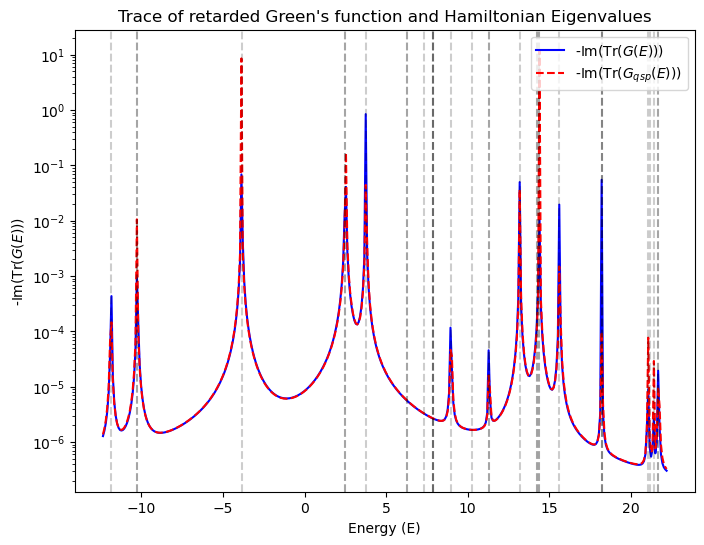

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

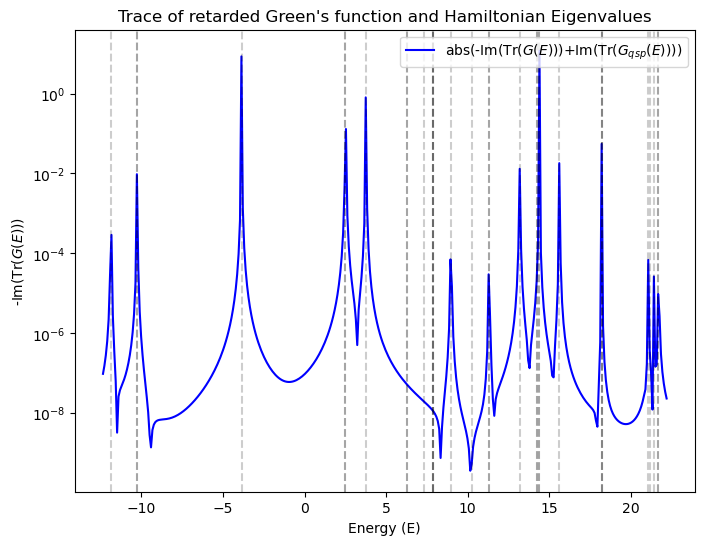

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [28]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [29]:
U_sweep = jnp.linspace(0, U, 11)

In [30]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 17 iterations.
-10.208498696370604
solve: 2
Converged in 17 iterations.
-10.033004846302415
solve: 3
Converged in 17 iterations.
-9.872091735055612
solve: 4
Converged in 16 iterations.
-9.724419113485139
solve: 5
Converged in 16 iterations.
-9.588745781306626
solve: 6
Converged in 16 iterations.
-9.463933343874075
solve: 7
Converged in 16 iterations.
-9.348933868496758
solve: 8
Converged in 16 iterations.
-9.242799457226273
solve: 9
Converged in 15 iterations.
-9.144683138442867
solve: 10
Converged in 15 iterations.
-9.053829339855517


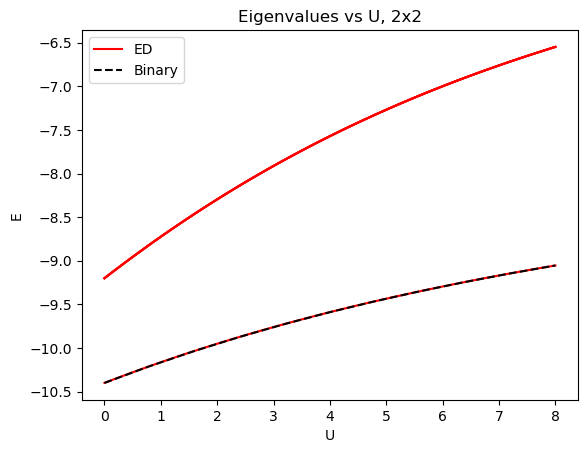

In [31]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [32]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [33]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

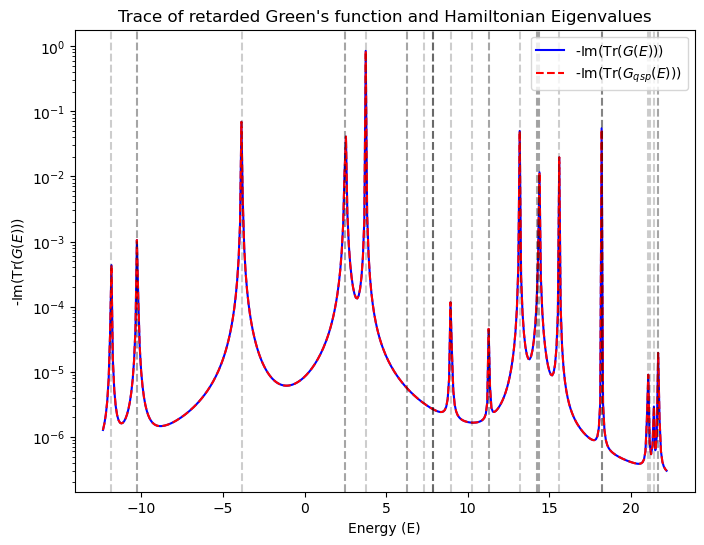

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

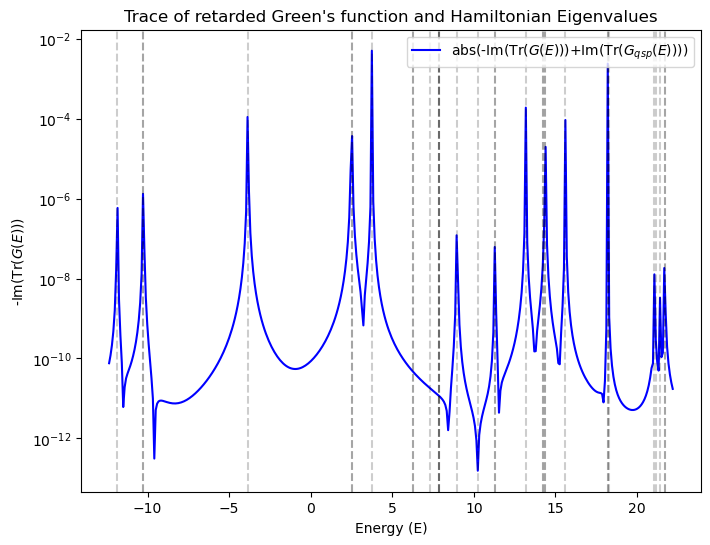

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [36]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [37]:
U_sweep = jnp.linspace(0, U, 11)

In [38]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 24 iterations.
-10.208498104816996
solve: 2
Converged in 23 iterations.
-10.033004555426496
solve: 3
Converged in 23 iterations.
-9.872092315937445
solve: 4
Converged in 23 iterations.
-9.724420946725353
solve: 5
Converged in 23 iterations.
-9.58874716343902
solve: 6
Converged in 23 iterations.
-9.463929220491735
solve: 7
Converged in 22 iterations.
-9.34892675785549
solve: 8
Converged in 22 iterations.
-9.242797206465907
solve: 9
Converged in 22 iterations.
-9.144690644484804
solve: 10
Converged in 22 iterations.
-9.053842967906867


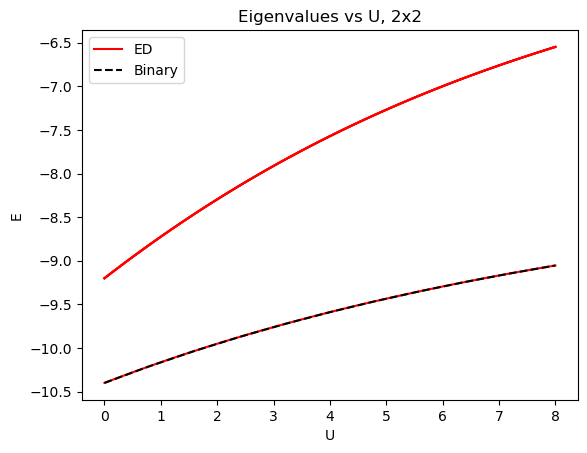

In [39]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [40]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [41]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

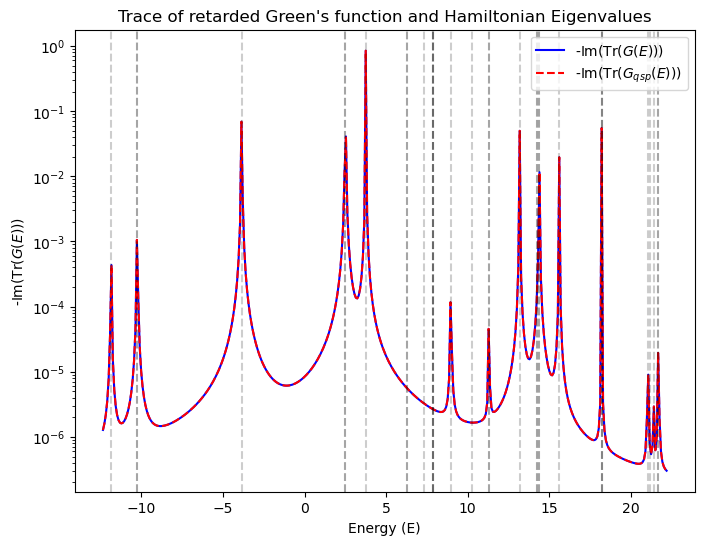

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

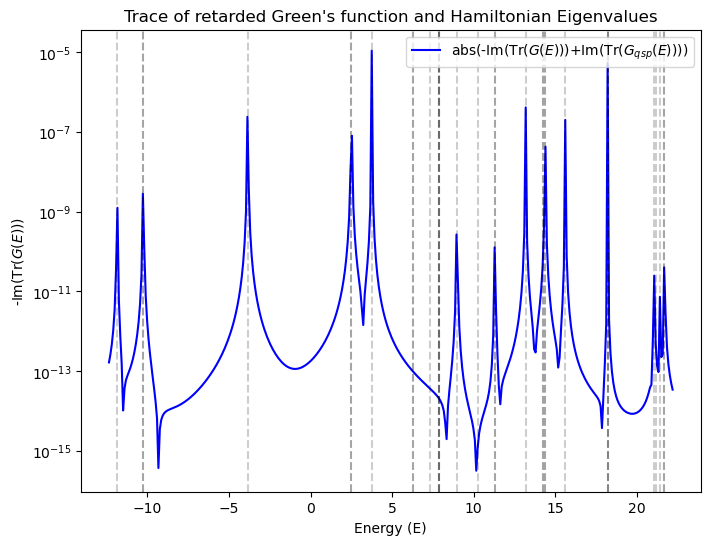

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# Wegstien's method

# error $ = 10^{-3}$

In [44]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [45]:
U_sweep = jnp.linspace(0, U, 11)

In [46]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-10.20849349754572
solve: 2
Converged in 1 iterations.
-10.032815941752517
solve: 3
Converged in 1 iterations.
-9.871456727550502
solve: 4
Converged in 2 iterations.
-9.723083296486818
solve: 5
Converged in 2 iterations.
-9.586658932114311
solve: 6
Converged in 2 iterations.
-9.461686538408381
solve: 7
Converged in 2 iterations.
-9.348156208735846
solve: 8
Converged in 2 iterations.
-9.24597200904735
solve: 9
Converged in 2 iterations.
-9.153853260383947
solve: 10
Converged in 2 iterations.
-9.068589198666503


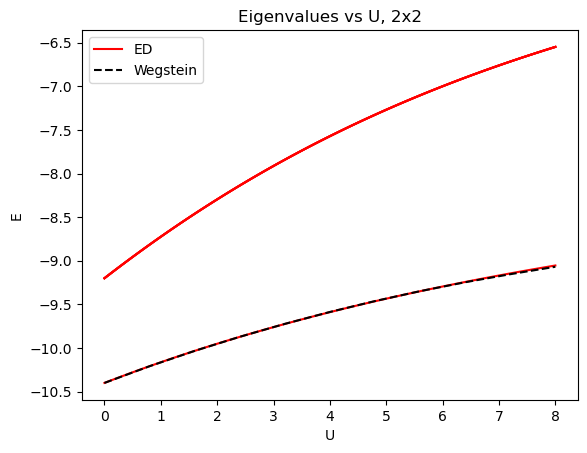

In [47]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [48]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [49]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

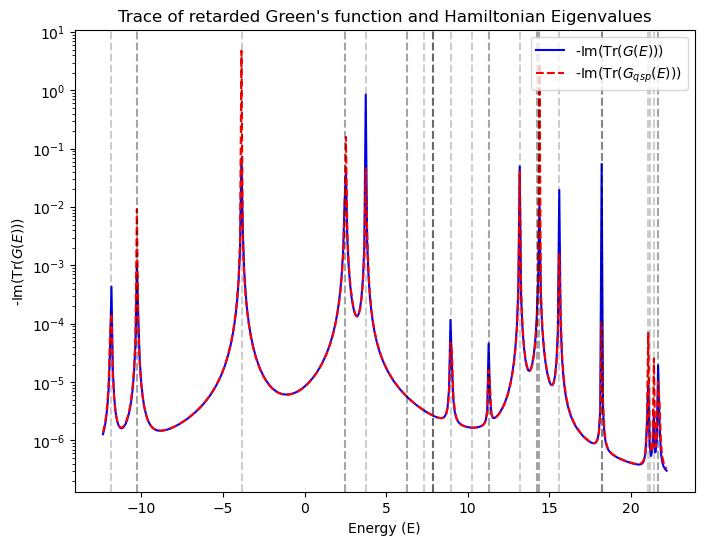

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

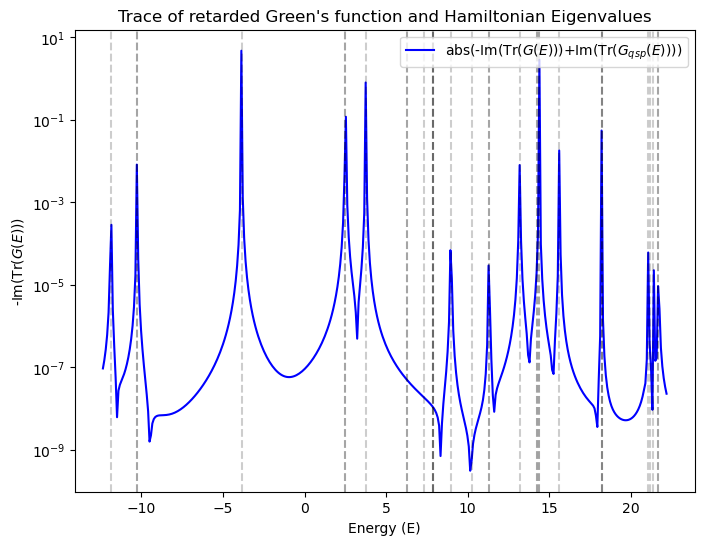

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [52]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [53]:
U_sweep = jnp.linspace(0, U, 11)

In [54]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-10.208497973788804
solve: 2
Converged in 2 iterations.
-10.033004203905293
solve: 3
Converged in 2 iterations.
-9.872091172727785
solve: 4
Converged in 2 iterations.
-9.724418133034527
solve: 5
Converged in 2 iterations.
-9.588744938337067
solve: 6
Converged in 2 iterations.
-9.463932623873685
solve: 7
Converged in 2 iterations.
-9.348933256137721
solve: 8
Converged in 2 iterations.
-9.242798937903997
solve: 9
Converged in 2 iterations.
-9.144682231630332
solve: 10
Converged in 2 iterations.
-9.05382856955165


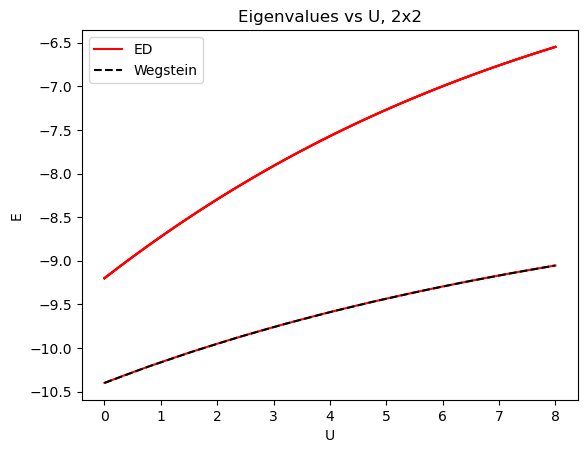

In [55]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [56]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [57]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

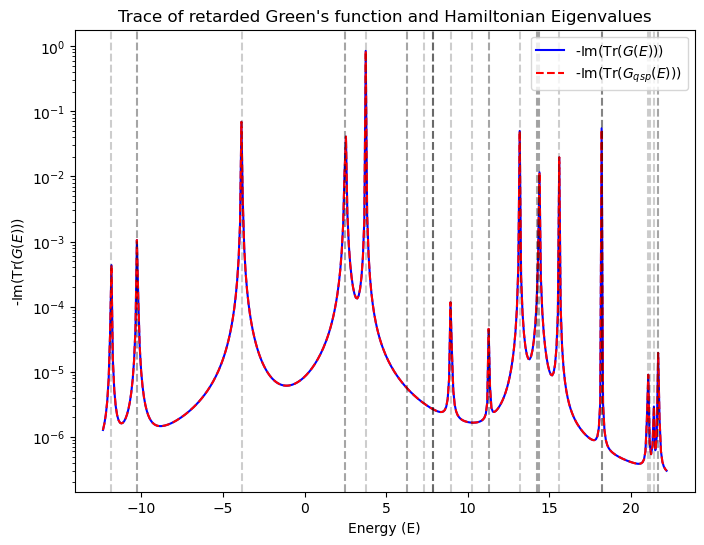

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

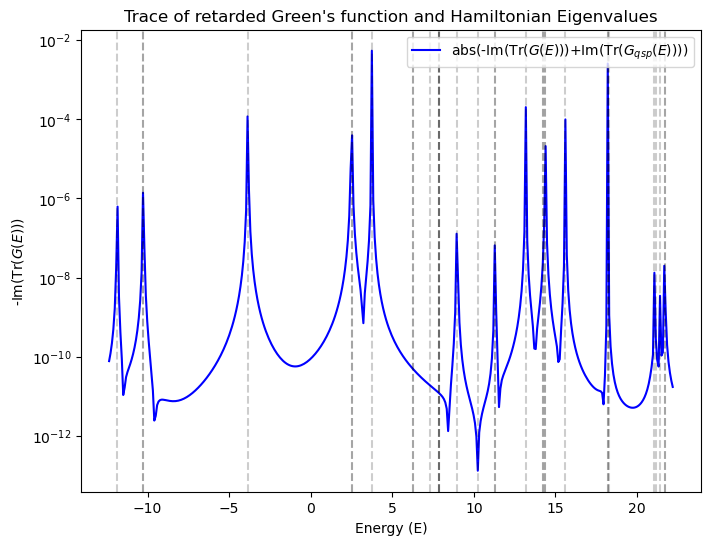

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [60]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [61]:
U_sweep = jnp.linspace(0, U, 11)

In [62]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-10.208498099195792
solve: 2
Converged in 5 iterations.
-10.03300454549516
solve: 3
Converged in 10 iterations.
-9.872092307606978
solve: 4
Converged in 6 iterations.
-9.724420939076825
solve: 5
Converged in 14 iterations.
-9.588747157284969
solve: 6
Converged in 7 iterations.
-9.463929215903562
solve: 7
Converged in 3 iterations.
-9.348926749241645
solve: 8
Converged in 4 iterations.
-9.242797200513579
solve: 9
Converged in 17 iterations.
-9.14469063892877
solve: 10
Converged in 12 iterations.
-9.053842963057827


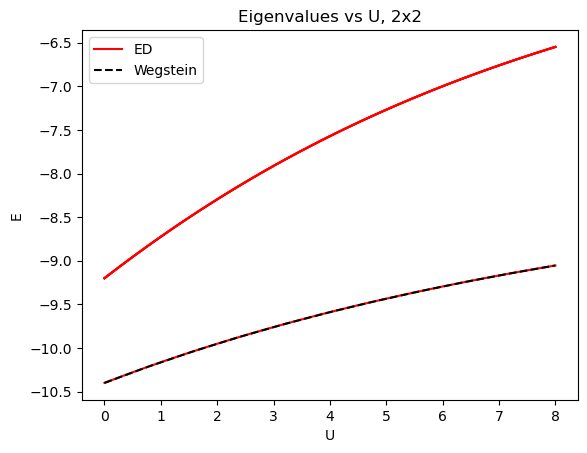

In [63]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [64]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [65]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

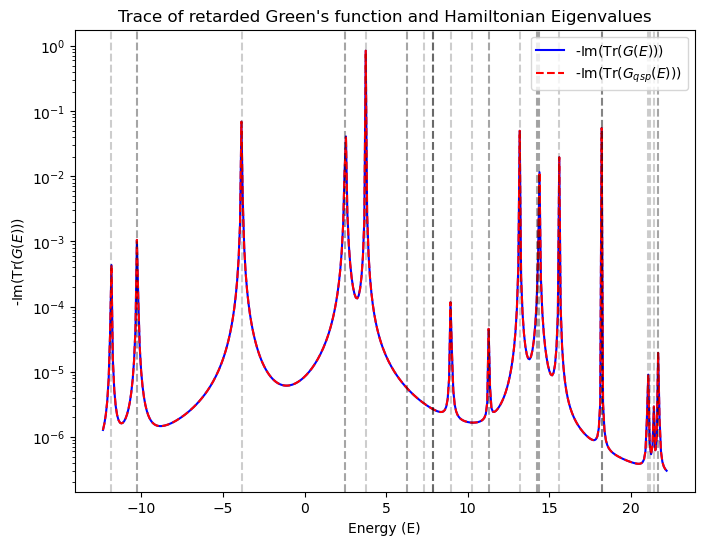

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

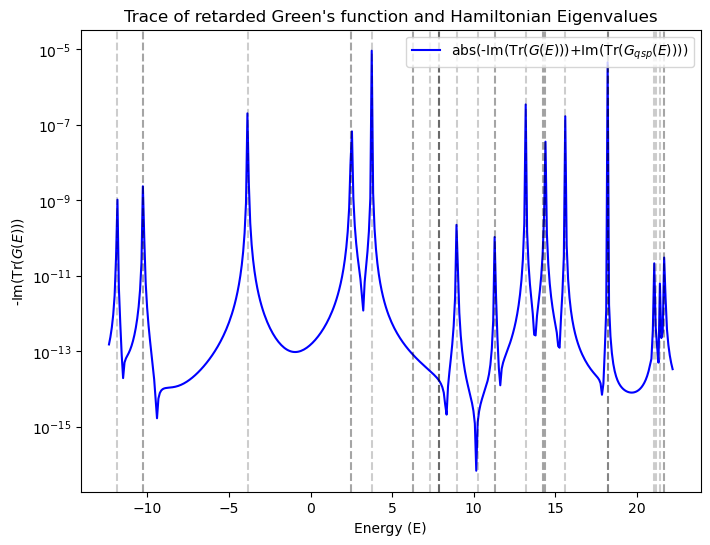

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()